In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
path = 'Resources/hawaii.sqlite'
engine = create_engine(f'sqlite:///{path}')

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
prev_year = calc_temps('2017-08-01', '2017-08-07')[0]
tmin = prev_year[0]
tavg = prev_year[1]
tmax = prev_year[2]
print(tmin, tavg, tmax)

72.0 79.25 83.0


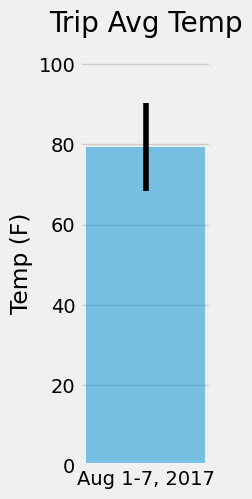

In [209]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin

fig, ax = plt.subplots(figsize=(1.5, 5))
ax.bar('Aug 1-7, 2017',height=tavg, yerr=yerr, alpha=0.5, align='center')
plt.title('Trip Avg Temp', y=1.05)
plt.ylabel('Temp (F)')
plt.ylim(0,101)
plt.grid(axis='x')
plt.savefig('Images/temperature.png', bbox_inches='tight')
plt.show()

### Daily Rainfall Average

In [60]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'
rain_per_station = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
    
rain_per_station

[('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519281', 0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

### Daily Temperature Normals

In [61]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [104]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=start_date, end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
month_day = trip_dates.strftime('%m-%d')
month_day

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(x) for x in month_day]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [117]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['col'], index=trip_dates)
normals_df['tmin'], normals_df['tavg'], normals_df['tmax'] = normals_df.col.str
normals_df.index.name = 'trip_dates'
normals_df = normals_df.iloc[:,1:4]
normals_df

C:\Users\parkm\AppData\Local\Temp\ipykernel_54004\3598203479.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  normals_df['tmin'], normals_df['tavg'], normals_df['tmax'] = normals_df.col.str


,tmin,tavg,tmax
trip_dates,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


In [195]:
# store dates to list
xticks = normals_df.index.tolist()
xticks

[Timestamp('2017-08-01 00:00:00', freq='D'),
 Timestamp('2017-08-02 00:00:00', freq='D'),
 Timestamp('2017-08-03 00:00:00', freq='D'),
 Timestamp('2017-08-04 00:00:00', freq='D'),
 Timestamp('2017-08-05 00:00:00', freq='D'),
 Timestamp('2017-08-06 00:00:00', freq='D'),
 Timestamp('2017-08-07 00:00:00', freq='D')]

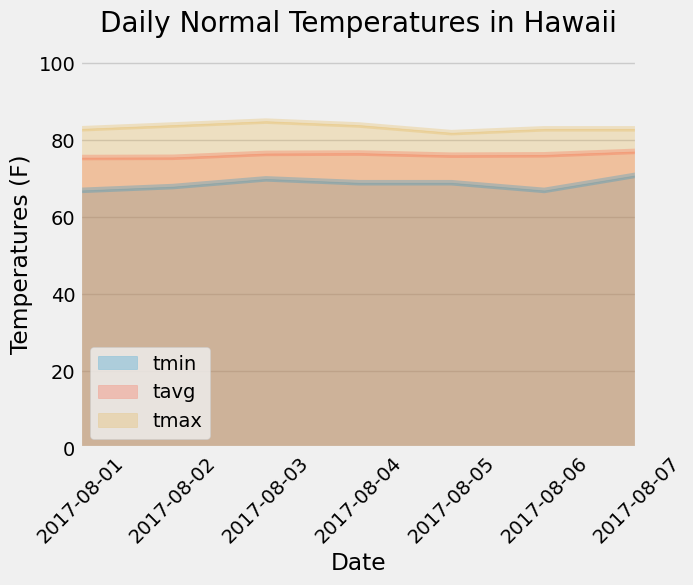

In [208]:
import matplotlib.dates as mdates

# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, alpha=0.25, rot=45)
plt.ylabel('Temperatures (F)')
plt.xlabel('Date')
plt.title('Daily Normal Temperatures in Hawaii', y=1.05)
plt.ylim(0,101)
plt.grid(axis='x')

# change date format x-axis 
myFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gca().xaxis.set_minor_formatter(myFmt)

plt.savefig('Images/daily-normals.png', bbox_inches='tight')
plt.show()

## Close Session

In [ ]:
session.close()